In [2]:
#Torch version for the vocoder
#Ignoid the Chinese annotation
#The functionality is exactly the same as the original vocoder

import pysndfile
import soundfile as sf
from datasets import load_dataset
import pandas as pd
import numpy as np
import random
import time
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torch.nn.functional as F
import torch
import functools

begin_fc=120
end_fc=8658
depths=[-0.1,-0.1,-0.1,-0.05,-0.05,-0.05,0.,0.,0.,0.05,0.05,0.05,0.1,0.1,0.1]
electroids_num=12
exp=1

def adjust_length(tensor1, tensor2):
    len1 = tensor1.size(0)  # 获取第一个张量的长度
    len2 = tensor2.size(0)  # 获取第二个张量的长度
    
    if len2 > len1:
        # 如果第二个张量长度较长，进行截断
        return tensor2[:len1]
    elif len2 < len1:
        # 如果第二个张量长度较短，使用最后一个元素进行填充
        last_element = tensor2[-1].item()  # 获取最后一个元素
        padding = last_element * torch.ones(len1 - len2)  # 创建一个填充用的张量
        return torch.cat((tensor2, padding))  # 连接原始张量和填充张量
    else:
        # 长度相等，直接返回第二个张量
        return tensor2

def predict(sig,fs):
    #给定信号，频率输出通过模型预测的句子
    input_values = processor(sig, sampling_rate=fs, return_tensors="pt").input_values
    # INFERENCE

    # retrieve logits & take argmax
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)

    # transcribe
    transcription = processor.decode(predicted_ids[0])
    # FINE-TUNE
    return (transcription)

def get_loss(sentense, sig, fs):
    input_values = processor(sig, sampling_rate=fs, return_tensors="pt").input_values
    # encode labels
    with processor.as_target_processor():
        labels = processor(sentense, return_tensors="pt").input_ids

    # compute loss by passing labels
    loss = model(input_values, labels=labels).loss
    return loss

def cfs_to_bands(cfs):
    m = torch.tensor([168] * (electroids_num + 1), dtype=cfs.dtype, device=cfs.device)  # 经验矫正项
    cuts = torch.log(cfs + m[1:])  # 使用 PyTorch 操作
    cuts = torch.cat([2 * cuts[0:1] - cuts[1:2], cuts, 2 * cuts[-1:] - cuts[-2:-1]])
    block = torch.exp((cuts[:-1] + cuts[1:]) / 2) - m
    bands = torch.stack([block[:-1], block[1:]], dim=1)
    return bands

#read sound files
def read_sound():
    librispeech_samples_ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
    sig_ls=[]
    sentenses=[]
    for i in range(0,70):
        (sig,fs,enc) = pysndfile.sndio.read(librispeech_samples_ds[i]["file"])
        sig_ls.append(sig)
        sentenses.append(predict(sig,fs))
    return sentenses, sig_ls, fs

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

def to_device(device):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            new_args = [arg.to(device) if isinstance(arg, torch.Tensor) else arg for arg in args]
            new_kwargs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in kwargs.items()}
            return func(*new_args, **new_kwargs)
        return wrapper
    return decorator

def conv1d_same(input_tensor, kernel_tensor):
    """
    Perform 1D convolution on input_tensor using kernel_tensor,
    mimicking the 'same' mode of np.convolve.
    
    Parameters:
        input_tensor (torch.Tensor): 1D input tensor.
        kernel_tensor (torch.Tensor): 1D kernel tensor.
    
    Returns:
        torch.Tensor: Output tensor after 1D convolution with same size as input_tensor.
    """
    if input_tensor.dim() != 1 or kernel_tensor.dim() != 1:
        raise ValueError("Both input_tensor and kernel_tensor must be 1D tensors.")
    
    input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, L]
    kernel_tensor = kernel_tensor.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, K]
    
    # Calculate the padding
    total_padding = kernel_tensor.size(2) - 1
    padding_left = total_padding // 2
    padding_right = total_padding - padding_left
    
    # Manually pad the input tensor
    padded_input_tensor = F.pad(input_tensor, (padding_left, padding_right))

    # Perform the convolution
    output_tensor = F.conv1d(padded_input_tensor, kernel_tensor)

    # Remove extra dimensions
    return output_tensor.squeeze()

/home/jyun/.conda/envs/bm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the mo

In [3]:
from tools import generate_cfs, generate_bands

fir_host = torch.tensor([  5.58149986e-05,   8.75499973e-06,   9.35499975e-06,
         1.01559999e-05,   1.08249997e-05,   1.16840001e-05,
         1.24170001e-05,   1.33450003e-05,   1.41609999e-05,
         1.51759996e-05,   1.60950003e-05,   1.72000000e-05,
         1.81889991e-05,   1.93129999e-05,   2.03950003e-05,
         2.17550005e-05,   2.28459994e-05,   2.42660008e-05,
         2.55199993e-05,   2.70210003e-05,   2.83959998e-05,
         3.00089996e-05,   3.14999997e-05,   3.32199998e-05,
         3.48299982e-05,   3.66749991e-05,   3.84240011e-05,
         4.03980011e-05,   4.22480007e-05,   4.43690005e-05,
         4.63879987e-05,   4.86300014e-05,   5.07959994e-05,
         5.31910009e-05,   5.55129991e-05,   5.80619999e-05,
         6.05470013e-05,   6.32730007e-05,   6.59200014e-05,
         6.88090004e-05,   7.16409995e-05,   7.47180020e-05,
         7.77340028e-05,   8.09870035e-05,   8.42060035e-05,
         8.76609993e-05,   9.10739982e-05,   9.47399967e-05,
         9.83589998e-05,   1.02238002e-04,   1.06077001e-04,
         1.10177003e-04,   1.14249997e-04,   1.18586999e-04,
         1.22893995e-04,   1.27466003e-04,   1.32029003e-04,
         1.36862000e-04,   1.41672994e-04,   1.46766994e-04,
         1.51849003e-04,   1.57218004e-04,   1.62582000e-04,
         1.68233993e-04,   1.73883993e-04,   1.79829003e-04,
         1.85783996e-04,   1.92035004e-04,   1.98305002e-04,
         2.04869997e-04,   2.11455001e-04,   2.18354005e-04,
         2.25274998e-04,   2.32510007e-04,   2.39785004e-04,
         2.47368996e-04,   2.54999992e-04,   2.62954010e-04,
         2.70958000e-04,   2.79286993e-04,   2.87676987e-04,
         2.96401995e-04,   3.05191003e-04,   3.14319012e-04,
         3.23521992e-04,   3.33069998e-04,   3.42701009e-04,
         3.52684001e-04,   3.62758001e-04,   3.73190996e-04,
         3.83718987e-04,   3.94616014e-04,   4.05617000e-04,
         4.16994997e-04,   4.28483996e-04,   4.40356991e-04,
         4.52351000e-04,   4.64735000e-04,   4.77250986e-04,
         4.90163977e-04,   5.03219024e-04,   5.16681001e-04,
         5.30289020e-04,   5.44312992e-04,   5.58506988e-04,
         5.73111989e-04,   5.87892020e-04,   6.03110006e-04,
         6.18499005e-04,   6.34342025e-04,   6.50370028e-04,
         6.66852982e-04,   6.83541992e-04,   7.00692006e-04,
         7.18056981e-04,   7.35899026e-04,   7.53963017e-04,
         7.72518979e-04,   7.91310973e-04,   8.10600992e-04,
         8.30143981e-04,   8.50196986e-04,   8.70517979e-04,
         8.91360978e-04,   9.12487973e-04,   9.34143027e-04,
         9.56102973e-04,   9.78610944e-04,   1.00142905e-03,
         1.02481595e-03,   1.04852801e-03,   1.07282400e-03,
         1.09746703e-03,   1.12270599e-03,   1.14831002e-03,
         1.17453199e-03,   1.20113394e-03,   1.22837303e-03,
         1.25601899e-03,   1.28431595e-03,   1.31304201e-03,
         1.34243804e-03,   1.37228903e-03,   1.40283303e-03,
         1.43385294e-03,   1.46559998e-03,   1.49783504e-03,
         1.53082598e-03,   1.56433904e-03,   1.59863394e-03,
         1.63348799e-03,   1.66914600e-03,   1.70537794e-03,
         1.74245995e-03,   1.78016000e-03,   1.81873096e-03,
         1.85796595e-03,   1.89810200e-03,   1.93894701e-03,
         1.98072894e-03,   2.02325708e-03,   2.06677592e-03,
         2.11108499e-03,   2.15642899e-03,   2.20260792e-03,
         2.24988209e-03,   2.29804195e-03,   2.34734989e-03,
         2.39761197e-03,   2.44907290e-03,   2.50155502e-03,
         2.55531096e-03,   2.61015398e-03,   2.66634696e-03,
         2.72369408e-03,   2.78247893e-03,   2.84250802e-03,
         2.90405797e-03,   2.96695507e-03,   3.03146197e-03,
         3.09741497e-03,   3.16511095e-03,   3.23435711e-03,
         3.30546498e-03,   3.37825692e-03,   3.45304608e-03,
         3.52965295e-03,   3.60842003e-03,   3.68918502e-03,
         3.77225899e-03,   3.85749293e-03,   3.94526077e-03,
         4.03539790e-03,   4.12827684e-03,   4.22374904e-03,
         4.32221591e-03,   4.42355918e-03,   4.52814996e-03,
         4.63594496e-03,   4.74730087e-03,   4.86220419e-03,
         4.98104095e-03,   5.10382699e-03,   5.23099303e-03,
         5.36255492e-03,   5.49898995e-03,   5.64038800e-03,
         5.78722404e-03,   5.93966199e-03,   6.09824108e-03,
         6.26313686e-03,   6.43500686e-03,   6.61408901e-03,
         6.80112792e-03,   6.99645281e-03,   7.20086694e-03,
         7.41484808e-03,   7.63937784e-03,   7.87502527e-03,
         8.12298059e-03,   8.38398933e-03,   8.65942240e-03,
         8.95035267e-03,   9.25841928e-03,   9.58499312e-03,
         9.93213058e-03,   1.03017101e-02,   1.06962901e-02,
         1.11183496e-02,   1.15712602e-02,   1.20583801e-02,
         1.25840604e-02,   1.31531404e-02,   1.37714203e-02,
         1.44457202e-02,   1.51843401e-02,   1.59970503e-02,
         1.68958306e-02,   1.78955793e-02,   1.90145392e-02,
         2.02756505e-02,   2.17086095e-02,   2.33514309e-02,
         2.52543706e-02,   2.74853706e-02,   3.01383100e-02,
         3.33461203e-02,   3.73048782e-02,   4.23147716e-02,
         4.88610305e-02,   5.77816404e-02,   7.06595778e-02,
         9.08864737e-02,   1.27281800e-01,   2.12181106e-01,
         6.36611581e-01], dtype=torch.float32)


def make_fir_filter(lo, hi, sf):
    """
    Makes a 512-point band-pass FIR filter using the host-windowing method
    (Abed & Cain, 1978, The Radio and Electronic Engineer, 46, 293-300).
    The filter is zero-phase (i.e. symmetrical).

    Arguments:
        - lo (float): Lower limit of the band (Hz)
        - hi (float): Higher limit of the band (Hz)
        - sf (float): Sampling frequency (Hz)

    Returns:
        - out (torch.Tensor)
    """
    nspecs = 1000
    nyquist = sf / 2.
    n_stopband_lo = int(lo / nyquist * nspecs)
    stopband_lo = torch.zeros(n_stopband_lo)
    n_passband = int(hi / nyquist * nspecs) - n_stopband_lo

    if nspecs - n_stopband_lo - n_passband < 0:
        passband = torch.ones(nspecs - n_stopband_lo)
        specs = torch.cat((stopband_lo, passband))
    else:
        passband = torch.ones(n_passband)
        n_stopband_hi = nspecs - n_stopband_lo - n_passband
        stopband_hi = torch.zeros(n_stopband_hi)
        specs = torch.cat((stopband_lo, passband, stopband_hi))

    band_lo = 0
    win = torch.zeros(256)
    b = torch.arange(256) - 255.5
    for i in range(nspecs):
        band_hi = torch.pi * (i + 1) / nspecs
        win += specs[i] * (torch.sin(b * band_hi) - torch.sin(b * band_lo))
        band_lo = band_hi

    # Assuming fir_host is defined elsewhere and is a tensor
    ar = torch.transpose(fir_host,0,-1) * win
    return torch.cat((ar, ar.flip(dims=[0])))

In [4]:
@to_device(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
def spyral(input, fs, cfs, n_carriers, spread, **kwargs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    analysis_lo = kwargs.get('analysis_lo', 120)
    analysis_hi = kwargs.get('analysis_hi', 8658)
    analysis_cutoffs = kwargs.get('analysis_cutoffs', None)
    carrier_lo = kwargs.get('carrier_lo', 20)
    carrier_hi = kwargs.get('carrier_hi', 20000)
    filt_env = kwargs.get('filt_env', 50)
    in_phase = kwargs.get('in_phase', False)
    fs = torch.tensor(fs, dtype=torch.float32, device=device)
    carrier_weights = kwargs.get('carrier_weights', torch.ones(n_carriers, dtype=torch.float32, device=device))

    lp_filter = torch.tensor(make_fir_filter(0, filt_env, fs.cpu()), dtype=torch.float32).to(device)
    carrier_fs = torch.tensor(generate_cfs(carrier_lo, carrier_hi, n_carriers), dtype=torch.float32).to(device)
    t = torch.arange(0, len(input) / fs, 1 / fs, device=device)
    
    if analysis_cutoffs is not None:
        ip_bands = torch.tensor(analysis_cutoffs, dtype=torch.float32).to(device)
    else:
        ip_bands = torch.tensor(generate_bands(analysis_lo, analysis_hi, cfs.size(0)), dtype=torch.float32).to(device)
        
    ip_bank = torch.zeros((cfs.size(0), 512), device=device)
    envelope = torch.zeros((cfs.size(0), len(input)), device=device)

    input = torch.tensor(input, dtype=torch.float32).to(device)
    for j in range(cfs.size(0)):
        ip_bank[j, :] = torch.tensor(make_fir_filter(ip_bands[j, 0].cpu(), ip_bands[j, 1].cpu(), fs.cpu()), dtype=torch.float32).to(device)
        speechband = conv1d_same(input, ip_bank[j, :])
        envelope[j, :] = conv1d_same(torch.relu(speechband), lp_filter)

    log_cfs = torch.log2(cfs).unsqueeze(1)
    log_carrier_fs = torch.log2(carrier_fs).unsqueeze(0)
    log_diff = torch.abs(log_cfs - log_carrier_fs)
    spread_term = spread / 10.0 * log_diff
    weights = 10.0 ** spread_term

    weights = weights.unsqueeze(1)
    envelope = envelope.unsqueeze(2)
    mixed_envelope = torch.sqrt((weights ** 2 * envelope ** 2).sum(dim=0))
    mixed_envelope = mixed_envelope.transpose(0, 1)

    out = torch.zeros(len(input), device=device)
    if in_phase:
        phases = torch.zeros(n_carriers, device=device)
    else:
        phases = torch.rand(n_carriers, device=device) * 2 * torch.pi

    for i in range(n_carriers):
        pre_out = torch.sin(phases[i] + (2.0 * torch.pi * carrier_fs[i] * t)) * carrier_weights[i]
        t_carrier = pre_out[:len(input)]
        out += mixed_envelope[i, :] * t_carrier

    return out * (torch.sqrt(torch.mean(input**2)) / torch.sqrt(torch.mean(out**2)))


def read_sound():
    librispeech_samples_ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
    sig_ls=[]
    sentenses=[]
    for i in range(0,70):
        (sig,fs,enc) = pysndfile.sndio.read(librispeech_samples_ds[i]["file"])
        sig_ls.append(sig)
        sentenses.append(predict(sig,fs))
    return sentenses, sig_ls, fs

In [5]:
#try
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#(sentenses,sig_ls, fs)=read_sound()
(sig,fs,enc) = pysndfile.sndio.read("/home/jyun/spyral/test/test_clean.wav")

cfs=torch.tensor([170.24556885946038, 281.16463055116645, 463.51350221850475, 559.6087265485511, 893.4513581664048, 1185.8990951489839, 1557.4261013139158, 2084.603426844409, 2867.9235861370726, 3858.105079081676, 5368.54994216142, 7056.845799076047],requires_grad=True,device=device)

import time
start_time = time.time()

sig_out = spyral(sig,fs,cfs, 80, -20)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

/tmp/ipykernel_788642/1970345934.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lp_filter = torch.tensor(make_fir_filter(0, filt_env, fs.cpu()), dtype=torch.float32).to(device)
/tmp/ipykernel_788642/1970345934.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ip_bank[j, :] = torch.tensor(make_fir_filter(ip_bands[j, 0].cpu(), ip_bands[j, 1].cpu(), fs.cpu()), dtype=torch.float32).to(device)


Elapsed time: 1.4904286861419678 seconds


In [12]:
#Automated gradient descent (not successfun,useless)
from torch.autograd import Variable
cfs=torch.tensor([200.24556885946038, 301.16463055116645, 463.51350221850475, 559.6087265485511, 893.4513581664048, 1185.8990951489839, 1557.4261013139158, 2084.603426844409, 2867.9235861370726, 3858.105079081676, 5368.54994216142, 6056.845799076047],requires_grad=True,device=device)
def print_grad(grad):
    print("cfs gradients:", grad)

cfs.register_hook(print_grad)

epochs=2
optimizer = torch.optim.Adam([cfs],lr=1)
for _ in range(epochs):  
    for i in range(0,70):
        optimizer.zero_grad()
        bands=cfs_to_bands(cfs)
        sig_out = spyral(sig_ls[i], fs, cfs, 80, -20, analysis_cutoffs=bands)
        loss=get_loss(sentenses[i],sig_out,fs)
        loss.backward()
        optimizer.step()
cfs

/tmp/ipykernel_1692098/1970345934.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lp_filter = torch.tensor(make_fir_filter(0, filt_env, fs.cpu()), dtype=torch.float32).to(device)
/tmp/ipykernel_1692098/1970345934.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ip_bands = torch.tensor(analysis_cutoffs, dtype=torch.float32).to(device)
/tmp/ipykernel_1692098/1970345934.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ip_bank[j, :] = torch.tensor(make_fir_filter(ip_bands[j, 0].cpu(), ip_bands[j, 1].cpu(), fs.cpu()), dtype=torch.

In [10]:
import torch
import random

# 定义初始模板
cfs_template = [170.62652458069715, 304.4569781186976, 443.2480939446434, 
                636.1655671694094, 882.2537673971374, 1198.5130992434893, 
                1571.212125611763, 2043.8947231455913, 2867.9235861370726, 
                3850.724519081056, 5408.82654849078, 7262.79695795936]

# 定义初始参数
population_size = 100
num_generations = 10
mutation_rate = 0.1
mutation_range = 50  # 设置扰动范围

# 生成初始种群
def generate_initial_population(template, size):
    population = []
    for _ in range(size):
        cfs = torch.tensor([value + random.uniform(-mutation_range, mutation_range) for value in template], requires_grad=False, device=device)
        population.append(cfs)
    return population

# 评估适应度函数
def evaluate_fitness(cfs):
    loss = 0
    bands = cfs_to_bands(cfs)
    for i in range(0, 70):
        sig_out = spyral(sig_ls[i], fs, cfs, 80, -20, analysis_cutoffs=bands)
        loss += get_loss(sentenses[i], sig_out, fs)
    return loss.item()

# 选择操作 (选择前8个表现最好的)
def select_top_k(population, fitnesses, k=8):
    sorted_population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0])]
    return sorted_population[:k]

# 交叉操作 (单点交叉)
def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = torch.cat((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = torch.cat((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

# 变异操作
def mutate(cfs, mutation_rate, end_fc=8000):
    # 经验矫正项，用于把cfs拉平成一个真正的直线
    m = torch.tensor([168.0] * 12, device=cfs.device)
    # 对数变换
    cuts = torch.log(cfs + m)
    # 计算变动的标准差，即原数值的百分比
    std_devs = torch.tensor([mutation_rate] * 12, device=cfs.device)
    # 生成正态分布的随机变动
    variations = torch.normal(mean=0.0, std=std_devs)
    # 随机选择三分之一的元素进行变动
    random_choose = random.sample(range(12), int(12 / 3))
    mask = torch.zeros(12, device=cfs.device)
    mask[random_choose] = 1
    variations = variations * mask
    # 应用变动
    cuts = cuts + variations
    new_cfs = torch.exp(cuts) - m
    # 确保cfs的最大值不超过end_fc
    if torch.max(new_cfs) >= end_fc:
        new_cfs[-1] = end_fc - 100
        new_cfs, _ = torch.sort(new_cfs)
    return new_cfs

# 遗传算法主过程
def genetic_algorithm():
    population = generate_initial_population(cfs_template, population_size)
    key=1
    for generation in range(num_generations):
        if key==1:
            fitnesses = [evaluate_fitness(cfs) for cfs in population]
            key=0
        next_generation = []
        
        # 选择前8个表现最好的个体
        top_k_parents = select_top_k(population, fitnesses, k=8)
        
        # 生成新的子代
        while len(next_generation) < population_size:
            parent1, parent2 = random.sample(top_k_parents, 2)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            next_generation.extend([child1, child2])
        
        population = next_generation[:population_size]
        fitnesses = [evaluate_fitness(cfs) for cfs in population]
        best_fitness = min(fitnesses)
        best_cfs = population[fitnesses.index(best_fitness)]
        
        print(f"Generation {generation + 1}, Best Fitness: {best_fitness}")
        print(f"Best cfs: {best_cfs}")

    return best_cfs

# 运行遗传算法
best_cfs = genetic_algorithm()
print(f"Best cfs after {num_generations} generations: {best_cfs}")

/tmp/ipykernel_1374548/1970345934.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lp_filter = torch.tensor(make_fir_filter(0, filt_env, fs.cpu()), dtype=torch.float32).to(device)
/tmp/ipykernel_1374548/1970345934.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ip_bands = torch.tensor(analysis_cutoffs, dtype=torch.float32).to(device)
/tmp/ipykernel_1374548/1970345934.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ip_bank[j, :] = torch.tensor(make_fir_filter(ip_bands[j, 0].cpu(), ip_bands[j, 1].cpu(), fs.cpu()), dtype=torch.

Generation 1, Best Fitness: 3454.20849609375
Best cfs: tensor([ 153.0007,  279.6416,  418.8749,  590.1750,  850.5483, 1121.5398,
        1530.6809, 2051.6682, 2763.9717, 3897.0820, 5418.2700, 7227.1377],
       device='cuda:0')
Generation 2, Best Fitness: 3456.4765625
Best cfs: tensor([ 178.8769,  374.1663,  419.6315,  623.1697,  822.8682, 1190.3467,
        1582.7736, 2079.9199, 2880.0779, 3940.9619, 5383.4517, 7087.8931],
       device='cuda:0')
Generation 3, Best Fitness: 3390.1162109375
Best cfs: tensor([ 150.7565,  351.9604,  475.8049,  681.0829,  813.6778, 1231.7095,
        1569.4215, 2017.3562, 2649.2224, 3851.0601, 5719.6577, 7391.5923],
       device='cuda:0')
Generation 4, Best Fitness: 3371.272216796875
Best cfs: tensor([ 150.7565,  327.8539,  475.8049,  673.0989,  810.4467, 1184.6544,
        1582.7736, 1987.4238, 2549.5198, 3967.8569, 5253.3892, 6841.7861],
       device='cuda:0')
Generation 5, Best Fitness: 3369.788330078125
Best cfs: tensor([ 153.9617,  327.8539,  475.8

cuda:0


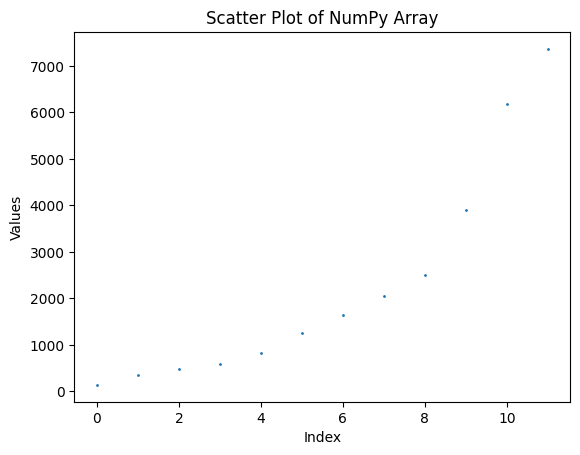

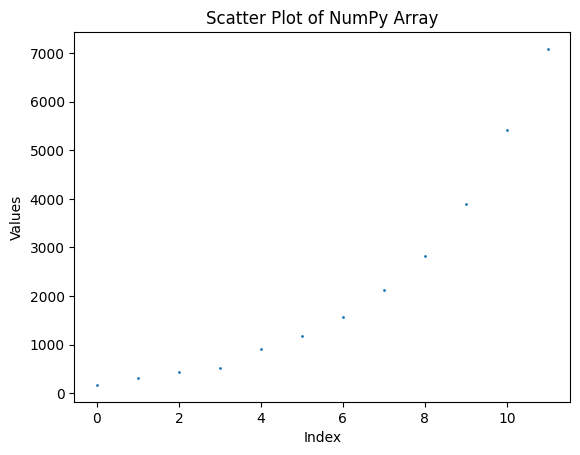

20

In [7]:
import matplotlib.pyplot as plt
import numpy as np
def draw_np_array(np_array):
    plt.scatter(np.arange(len(np_array)), np_array, s=1)
    plt.title('Scatter Plot of NumPy Array')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.show()
print(device)
draw_np_array([ 140.8823,  358.0166,  475.8049,  600.2462,  835.7512, 1254.7777,
        1639.7769, 2059.2764, 2496.4717, 3896.0627, 6182.3403, 7367.2852])
draw_np_array([ 170.3135,  314.6392,  434.1297,  515.8748,  915.1014, 1175.8121,
        1568.7499, 2121.6570, 2823.0693, 3893.2271, 5409.6372, 7088.3955])
